In [1]:
# Standard library
from datetime import datetime
from pathlib import Path
from time import sleep
import json
import os

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import papermill as pm
from matplotlib import colormaps
from matplotlib.colors import Normalize
from scipy.stats import gaussian_kde
from tqdm.notebook import tqdm

# Show all rows and prevent column truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)  # Auto-detect width

# Set global plot params
plt.rcParams.update({
    'font.size': 18,            # Base font size
    'axes.titlesize': 20,       # Title font
    'axes.labelsize': 18,       # Axis labels
    'xtick.labelsize': 16,      # X tick labels
    'ytick.labelsize': 16,      # Y tick labels
    'legend.fontsize': 16,      # Legend
    'figure.titlesize': 22      # Figure title
})

In [2]:
row_order = [
    "CIC_IDS_2017_Multiclass",
    "CIC_IOT_Dataset2023_Multiclass",
    "IoT_23_Multiclass",
    "IoT_Network_Intrusion_Macro_Multiclass",
    "IoT_Network_Intrusion_Micro_Multiclass",
    "KDD_Cup_1999_Multiclass",
    "UNSW_NB15_Multiclass",
    "BCCC_CIC-BCCC-NRC-ACI-IOT-2023_Multiclass",
    "BCCC_CIC-BCCC-NRC-Edge-IIoTSet-2022_Multiclass",
    "BCCC_CIC-BCCC-NRC-IoMT-2024_Multiclass",
    "BCCC_CIC-BCCC-NRC-IoT-2022_Multiclass",
    "BCCC_CIC-BCCC-NRC-IoT-2023-Original_Training_and_Testing_Multiclass",
    "BCCC_CIC-BCCC-NRC-IoT-HCRL-2019_Multiclass",
    "BCCC_CIC-BCCC-NRC-MQTTIoT-IDS-2020_Multiclass",
    "BCCC_CIC-BCCC-NRC-TONIoT-2021_Multiclass",
    "BCCC_CIC-BCCC-NRC-UQ-IOT-2022_Multiclass",
    "BoT_IoT_Macro_Multiclass",
    "BoT_IoT_Micro_Multiclass",
    "CICAPT_IIoT_Phase1_Macro_Multiclass", # nok (single-class)
    "CICAPT_IIoT_Phase1_Micro_Multiclass", # nok (single-class)
    "CICAPT_IIoT_Phase2_Macro_Multiclass",
    "CICAPT_IIoT_Phase2_Micro_Multiclass",
    "CICEVSE2024_EVSE-A_Macro_Multiclass",
    "CICEVSE2024_EVSE-A_Micro_Multiclass",
    "CICEVSE2024_EVSE-B_Macro_Multiclass",
    "CICEVSE2024_EVSE-B_Micro_Multiclass",
    "CICIoMT2024_Bluetooth_Multiclass",
    "CICIoMT2024_WiFi_and_MQTT_Multiclass",
    "CICIoV2024_Decimal_Macro_Multiclass",
    "CICIoV2024_Decimal_Micro_Multiclass",
    "EDGE-IIOTSET_DNN-EdgeIIoT_Multiclass",
    "EDGE-IIOTSET_ML-EdgeIIoT_Multiclass",
    "MQTT_IoT_IDS2020_BiflowFeatures_Multiclass",
    "MQTT_IoT_IDS2020_PacketFeatures_Multiclass",
    "MQTT_IoT_IDS2020_UniflowFeatures_Multiclass",
    "NIDS_CIC-BoT-IoT_Multiclass",
    "NIDS_CIC-ToN-IoT_Multiclass",
    "NIDS_NF-BoT-IoT_Multiclass",
    "NIDS_NF-BoT-IoT-v2_Multiclass",
    "NIDS_NF-BoT-IoT-v3_Multiclass",
    "NIDS_NF-CICIDS2018-v3_Multiclass",
    "NIDS_NF-CSE-CIC-IDS2018_Multiclass",
    "NIDS_NF-CSE-CIC-IDS2018-v2_Multiclass",
    "NIDS_NF-ToN-IoT_Multiclass",
    "NIDS_NF-ToN-IoT-v2_Multiclass",
    "NIDS_NF-ToN-IoT-v3_Multiclass",
    "NIDS_NF-UNSW-NB15_Multiclass",
    "NIDS_NF-UNSW-NB15-v2_Multiclass",
    "NIDS_NF-UNSW-NB15-v3_Multiclass",
    "NIDS_NF-UQ-NIDS_Multiclass",
    "NIDS_NF-UQ-NIDS-v2_Multiclass",
    "N_BaIoT_Danmini_Doorbell_Multiclass",
    "N_BaIoT_Ecobee_Thermostat_Multiclass",
    "N_BaIoT_Ennio_Doorbell_Multiclass",
    "N_BaIoT_Philips_B120N10_Baby_Monitor_Multiclass",
    "N_BaIoT_Provision_PT_737E_Security_Camera_Multiclass",
    "N_BaIoT_Provision_PT_838_Security_Camera_Multiclass",
    "N_BaIoT_Samsung_SNH_1011_N_Webcam_Multiclass",
    "N_BaIoT_SimpleHome_XCS7_1002_WHT_Security_Camera_Multiclass",
    "N_BaIoT_SimpleHome_XCS7_1003_WHT_Security_Camera_Multiclass",
    "ToN_IoT_IoT_Fridge_Multiclass",
    "ToN_IoT_IoT_GPS_Tracker_Multiclass",
    "ToN_IoT_IoT_Garage_Door_Multiclass",
    "ToN_IoT_IoT_Modbus_Multiclass",
    "ToN_IoT_IoT_Motion_Light_Multiclass",
    "ToN_IoT_IoT_Thermostat_Multiclass",
    "ToN_IoT_IoT_Weather_Multiclass",
    "ToN_IoT_Linux_Disk_Multiclass",
    "ToN_IoT_Linux_Memory_Multiclass",
    "ToN_IoT_Linux_Process_Multiclass",
    "ToN_IoT_Network_Multiclass",
    "ToN_IoT_Windows_10_Multiclass",
    "ToN_IoT_Windows_7_Multiclass"
]

In [3]:
def now():
    now = datetime.now()
    yyyymmdd_hhmmss_part = now.strftime('%Y-%m-%d %H:%M:%S')
    ms_part = f'{int(now.microsecond / 1000):03d}'
    return f'{yyyymmdd_hhmmss_part},{ms_part}'

def blend_with_white(rgb, alpha):
    return [1 - alpha * (1 - c) for c in rgb]

def format_and_color_columns(df, color_map_dict={}, alpha=0.0):
    df_colored = df.copy()

    for col in df.columns:
        col_data = df[col]

        # === Step 1: Apply your custom formatting ===
        if pd.api.types.is_float_dtype(col_data):
            if 'time' in col:
                formatted = col_data.map(lambda x: f"{x:,.1f}")
            elif 'size' in col:
                formatted = col_data.map(lambda x: f"{x:,.2f}")
            else:
                formatted = col_data.map(lambda x: f"{x:,.3f}")
        elif pd.api.types.is_integer_dtype(col_data):
            formatted = col_data.map(lambda x: f"{x:,}")
        else:
            formatted = col_data.astype(str)

        # === Step 2: Apply LaTeX color using colormap if specified ===
        if col in color_map_dict and pd.api.types.is_numeric_dtype(col_data):
            cmap = colormaps[color_map_dict[col]]
            valid_mask = col_data.notna()
            norm = Normalize(vmin=col_data[valid_mask].min(), vmax=col_data[valid_mask].max())
    
            # Start with string-typed formatted column
            colored_column = formatted.astype(str).copy()
    
            # Compute blended RGB
            rgba_colors = cmap(norm(col_data[valid_mask]))[:, :3]
            blended_colors = [blend_with_white(rgb, alpha=alpha) for rgb in rgba_colors]
    
            for i, (r, g, b) in zip(col_data[valid_mask].index, blended_colors):
                df_colored.loc[i, col] = (
                    f"\\cellcolor[rgb]{{{r:.3f}, {g:.3f}, {b:.3f}}} {formatted[i]}"
                )
        else:
            df_colored[col] = formatted

    return df_colored

# Samples, Features, Classes, Dtypes, Ftypes, Complexity

In [4]:
def get_full_shape(df_filename):
    df = pd.read_parquet(df_filename)
    n_rows, n_cols = df.shape
    n_cols -= 1 # discard target
    n_labels = df['label'].nunique()
    return n_rows, n_cols, n_labels

def get_dtypes(df_filename):
    df = pd.read_parquet(df_filename).drop(columns=['label'])
    dtypes = set([str(x) for x in df.dtypes.tolist()])

    numerical_types = {'int8', 'int16', 'int32', 'int64',
                       'uint8', 'uint16', 'uint32', 'uint64',
                       'float16', 'float32', 'float64'}
    categorical_types = {'category'}

    if dtypes.issubset(numerical_types):
        feature_type = 'numerical'
    elif dtypes.issubset(categorical_types):
        feature_type = 'categorical'
    elif dtypes & numerical_types and dtypes & categorical_types:
        feature_type = 'mixed'
    else:
        feature_type = 'unknown'  # catch-all for object, bool, etc.

    return dtypes, feature_type

def get_complexity_metrics(dataset_name):
    metrics_filename = os.path.join(
        metrics_folder, f'{dataset_name}_complexity.json'
    )
    with open(metrics_filename, 'r', encoding='utf-8') as fp:
        metrics = json.load(fp)
    return metrics

def get_overall_difficulty(dataset_name):
    # Generated from complexity_parser.ipynb
    with open('tables/complexity_metrics.json', 'r', encoding='utf-8') as fp:
        metrics = json.load(fp)
    return metrics.get(dataset_name, {}).get('overall_difficulty', np.nan)

In [5]:
dataset_folder = Path("/home/automl/git/iot-threat-classifier/2025-07-05/Input_Multiclass")

file_sizes = {}
shapes = {}
dtypes = {}
feature_types = {}

# Find all .parquet files recursively
parquet_files = list(dataset_folder.rglob("*.parquet"))

# Sort by file size (ascending)
parquet_files_sorted = sorted(parquet_files, key=lambda p: os.path.getsize(p))

# Iterate
for file in tqdm(parquet_files_sorted, desc='File', leave='False'):

    try:
        file_sizes[file.stem] = os.path.getsize(file) / 1024 / 1024
        shapes[file.stem] = get_full_shape(file)
        _dtypes, _feature_types = get_dtypes(file)
        dtypes[file.stem] = _dtypes
        feature_types[file.stem] = _feature_types
        
    except (ValueError, Exception) as e:
        tqdm.write(f'[{now()}] ERROR      | FILE = {str(file.stem):<64} | EXCEPTION = {e}')

File:   0%|          | 0/75 [00:00<?, ?it/s]

In [6]:
complexity_folder = Path("/home/automl/git/iot-threat-classifier/2025-07-05/Output_Multiclass/100_pct")

# Build the DataFrame
df_difficulty = pd.DataFrame({
    'size_mb': file_sizes,
    'samples': {k: v[0] for k, v in shapes.items()}, 
    'features': {k: v[1] for k, v in shapes.items()},
    'classes': {k: v[2] for k, v in shapes.items()},
    'dtypes': dtypes,
    'feature_types': feature_types
})

# Set index using the row labels (i.e., filenames)
df_difficulty.index.name = "filename"

df_difficulty['overall_difficulty'] = df_difficulty.index.to_series().apply(get_overall_difficulty)

# Filter custom_order to only include datasets that exist in the DataFrame
valid_order = [d for d in row_order if d in df_difficulty.index]

# Reorder using the filtered list
df_difficulty = df_difficulty.loc[valid_order]

df_difficulty

,size_mb,samples,features,classes,dtypes,feature_types,overall_difficulty
filename,,,,,,,
CIC_IDS_2017_Multiclass,48.120055,1250066,70,15,"{int32, category, int64}",mixed,0.520255
CIC_IOT_Dataset2023_Multiclass,103.467662,4487800,39,35,"{int64, int32, category, float64, float32}",mixed,0.463287
IoT_23_Multiclass,1.983605,363889,12,16,"{int32, category, float32}",mixed,0.647499
IoT_Network_Intrusion_Macro_Multiclass,0.388587,78938,24,5,"{int32, category, float64}",mixed,0.579553
IoT_Network_Intrusion_Micro_Multiclass,0.388876,78963,24,11,"{int32, category, float64}",mixed,0.576441
KDD_Cup_1999_Multiclass,6.023224,1074992,40,23,"{int32, category, int64, float32}",mixed,0.531696
UNSW_NB15_Multiclass,46.291736,1944769,45,11,"{int64, int32, category, float64, float32}",mixed,0.599471
BCCC_CIC-BCCC-NRC-ACI-IOT-2023_Multiclass,12.335672,292898,73,12,"{int64, int32, category, float64, float32}",mixed,0.573121
BCCC_CIC-BCCC-NRC-Edge-IIoTSet-2022_Multiclass,22.411199,1175500,69,12,"{int64, int32, category, float64, float32}",mixed,0.519026


In [7]:
df_difficulty.shape

(73, 7)

In [8]:
df_difficulty_pretty = format_and_color_columns(
    df_difficulty.drop(columns=['size_mb', 'dtypes']).loc[row_order],
    color_map_dict={'overall_difficulty': 'RdYlGn_r'},
    alpha=0.5
)

with open("tables/table_2.tex", "w") as f:
    f.write(df_difficulty_pretty.to_string())

df_difficulty_pretty

/tmp/ipykernel_8411/3538409023.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '\cellcolor[rgb]{0.963, 0.985, 0.825} 0.520' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_colored.loc[i, col] = (


,samples,features,classes,feature_types,overall_difficulty
filename,,,,,
CIC_IDS_2017_Multiclass,"1,250,066",70,15,mixed,"\cellcolor[rgb]{0.963, 0.985, 0.825} 0.520"
CIC_IOT_Dataset2023_Multiclass,"4,487,800",39,35,mixed,"\cellcolor[rgb]{0.813, 0.920, 0.706} 0.463"
IoT_23_Multiclass,"363,889",12,16,mixed,"\cellcolor[rgb]{0.970, 0.695, 0.623} 0.647"
IoT_Network_Intrusion_Macro_Multiclass,"78,938",24,5,mixed,"\cellcolor[rgb]{0.998, 0.916, 0.753} 0.580"
IoT_Network_Intrusion_Micro_Multiclass,"78,963",24,11,mixed,"\cellcolor[rgb]{0.998, 0.928, 0.763} 0.576"
KDD_Cup_1999_Multiclass,"1,074,992",40,23,mixed,"\cellcolor[rgb]{0.990, 0.996, 0.861} 0.532"
UNSW_NB15_Multiclass,"1,944,769",45,11,mixed,"\cellcolor[rgb]{0.997, 0.862, 0.708} 0.599"
BCCC_CIC-BCCC-NRC-ACI-IOT-2023_Multiclass,"292,898",73,12,mixed,"\cellcolor[rgb]{0.998, 0.935, 0.769} 0.573"
BCCC_CIC-BCCC-NRC-Edge-IIoTSet-2022_Multiclass,"1,175,500",69,12,mixed,"\cellcolor[rgb]{0.961, 0.983, 0.821} 0.519"


# $F_1$ Score, Training Time, Model Size

In [9]:
base_folder = Path("/home/automl/git/iot-threat-classifier/2025-07-05/Output_Multiclass_3600")

def get_model_size(dataset_name, stage):
    ds_folder = os.path.join(base_folder, dataset_name)
    model_filename = os.path.join(ds_folder, f'xgb_{stage}_model.json')
    size_bytes = os.path.getsize(model_filename)
    return size_bytes

def get_scores(dataset_name, stage):
    results = {}
    ds_folder = os.path.join(base_folder, dataset_name)
    if stage.lower() in ['full', 'sampled', 'reduced', 'filtered']:
        metric_filename = os.path.join(ds_folder, f'xgb_{stage.lower()}_metrics.json')
        try:
            with open(metric_filename, 'r', encoding='utf-8') as fp:
                results = json.load(fp)
        except Exception as e:
            print(f'Could not open {metric_filename}. Reason: {str(e)}')
            results = {}
    elif stage.lower() == 'hpo':
        metric_filename = os.path.join(ds_folder, 'xgb_hpo_trials.xlsx')
        try:
            results_df = pd.read_excel(metric_filename).dropna()
            
            # Convert datetime columns to actual datetime objects
            results_df["datetime_start"] = pd.to_datetime(results_df["datetime_start"])
            results_df["datetime_complete"] = pd.to_datetime(results_df["datetime_complete"])
            
            # Calculate training time as a new column
            results_df["training_time_sec"] = (results_df["datetime_complete"] - results_df["datetime_start"]).dt.total_seconds()

            model_sizes = [
                get_model_size(dataset_name, 'best_balance') / 1024 / 1024,
                get_model_size(dataset_name, 'best_latency') / 1024 / 1024,
                get_model_size(dataset_name, 'best_weighted_f1_score') / 1024 / 1024,
            ]
            
            results = {
                'training_time': {
                    'min': results_df['training_time_sec'].min(),
                    'max': results_df['training_time_sec'].max(),
                    'mean': results_df['training_time_sec'].mean(),
                    'std': results_df['training_time_sec'].std(),
                },
                'latency': {
                    'min': results_df['latency'].min(),
                    'max': results_df['latency'].max(),
                    'mean': results_df['latency'].mean(),
                    'std': results_df['latency'].std(),
                },
                'f1_score': {
                    'min': results_df['f1_score'].min(),
                    'max': results_df['f1_score'].max(),
                    'mean': results_df['f1_score'].mean(),
                    'std': results_df['f1_score'].std(),
                },
                'size': {
                    'min': np.min(model_sizes),
                    'max': np.max(model_sizes),
                    'mean': np.mean(model_sizes),
                    'std': np.std(model_sizes),
                }
            }
        except Exception as e:
            print(f'Could not open {metric_filename}. Reason: {str(e)}')
            results = {
                'training_time': {
                    'min': np.nan,
                    'max': np.nan,
                    'mean': np.nan,
                    'std': np.nan,
                },
                'latency': {
                    'min': np.nan,
                    'max': np.nan,
                    'mean': np.nan,
                    'std': np.nan,
                },
                'f1_score': {
                    'min': np.nan,
                    'max': np.nan,
                    'mean': np.nan,
                    'std': np.nan,
                },
                'size': {
                    'min': np.nan,
                    'max': np.nan,
                    'mean': np.nan,
                    'std': np.nan,
                }
            }
    return results

In [10]:
for dataset_name in df_difficulty.index:
    try:
        # Extract metrics
        new_data = {
            # f1 scores
            'f1_full': get_scores(dataset_name, 'full').get('f1_weighted', np.nan),
            'f1_sampled': get_scores(dataset_name, 'sampled').get('f1_weighted', np.nan),
            'f1_reduced': get_scores(dataset_name, 'reduced').get('f1_weighted', np.nan),
            'f1_filtered': get_scores(dataset_name, 'filtered').get('f1_weighted', np.nan),
            'f1_hpo_min': get_scores(dataset_name, 'hpo').get('f1_score', {}).get('min', np.nan),
            'f1_hpo_max': get_scores(dataset_name, 'hpo').get('f1_score', {}).get('max', np.nan),
            'f1_hpo_mean': get_scores(dataset_name, 'hpo').get('f1_score', {}).get('mean', np.nan),
            'f1_hpo_std': get_scores(dataset_name, 'hpo').get('f1_score', {}).get('std', np.nan),
            # training times
            'time_full': get_scores(dataset_name, 'full').get('training_time', np.nan),
            'time_sampled': get_scores(dataset_name, 'sampled').get('training_time', np.nan),
            'time_reduced': get_scores(dataset_name, 'reduced').get('training_time', np.nan),
            'time_filtered': get_scores(dataset_name, 'filtered').get('training_time', np.nan),
            'time_hpo_min': get_scores(dataset_name, 'hpo').get('training_time', {}).get('min', np.nan),
            'time_hpo_max': get_scores(dataset_name, 'hpo').get('training_time', {}).get('max', np.nan),
            'time_hpo_mean': get_scores(dataset_name, 'hpo').get('training_time', {}).get('mean', np.nan),
            'time_hpo_std': get_scores(dataset_name, 'hpo').get('training_time', {}).get('std', np.nan),
            # size
            'size_full': get_scores(dataset_name, 'full').get('model_size', np.nan),
            'size_sampled': get_scores(dataset_name, 'sampled').get('model_size', np.nan),
            'size_reduced': get_scores(dataset_name, 'reduced').get('model_size', np.nan),
            'size_filtered': get_scores(dataset_name, 'filtered').get('model_size', np.nan),
            'size_hpo_min': get_scores(dataset_name, 'hpo').get('size', {}).get('min', np.nan),
            'size_hpo_max': get_scores(dataset_name, 'hpo').get('size', {}).get('max', np.nan),
            'size_hpo_mean': get_scores(dataset_name, 'hpo').get('size', {}).get('mean', np.nan),
            'size_hpo_std': get_scores(dataset_name, 'hpo').get('size', {}).get('std', np.nan),
        }

        # Assign values into the existing df_pretty using .at
        for col, val in new_data.items():
            df_difficulty.at[dataset_name, col] = val

    except Exception as e:
        print(f"Skipping {dataset_name} due to: {e}")

df_difficulty

Could not open /home/automl/git/iot-threat-classifier/2025-07-05/Output_Multiclass_3600/CICAPT_IIoT_Phase1_Macro_Multiclass/xgb_full_metrics.json. Reason: [Errno 2] No such file or directory: '/home/automl/git/iot-threat-classifier/2025-07-05/Output_Multiclass_3600/CICAPT_IIoT_Phase1_Macro_Multiclass/xgb_full_metrics.json'
Could not open /home/automl/git/iot-threat-classifier/2025-07-05/Output_Multiclass_3600/CICAPT_IIoT_Phase1_Macro_Multiclass/xgb_sampled_metrics.json. Reason: [Errno 2] No such file or directory: '/home/automl/git/iot-threat-classifier/2025-07-05/Output_Multiclass_3600/CICAPT_IIoT_Phase1_Macro_Multiclass/xgb_sampled_metrics.json'
Could not open /home/automl/git/iot-threat-classifier/2025-07-05/Output_Multiclass_3600/CICAPT_IIoT_Phase1_Macro_Multiclass/xgb_reduced_metrics.json. Reason: [Errno 2] No such file or directory: '/home/automl/git/iot-threat-classifier/2025-07-05/Output_Multiclass_3600/CICAPT_IIoT_Phase1_Macro_Multiclass/xgb_reduced_metrics.json'
Could not ope

,size_mb,samples,features,classes,dtypes,feature_types,overall_difficulty,f1_full,f1_sampled,f1_reduced,f1_filtered,f1_hpo_min,f1_hpo_max,f1_hpo_mean,f1_hpo_std,time_full,time_sampled,time_reduced,time_filtered,time_hpo_min,time_hpo_max,time_hpo_mean,time_hpo_std,size_full,size_sampled,size_reduced,size_filtered,size_hpo_min,size_hpo_max,size_hpo_mean,size_hpo_std
filename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CIC_IDS_2017_Multiclass,48.120055,1250066,70,15,"{int32, category, int64}",mixed,0.520255,0.999263,0.998707,0.996949,0.991532,0.545708,0.991472,0.897433,0.109268,7.672563,8.555579,8.779546,3.655761,4.338,11.311,6.810643,1.323494,2.70,2.48,2.23,0.90,0.093451,2.869674,1.763736,1.201587
CIC_IOT_Dataset2023_Multiclass,103.467662,4487800,39,35,"{int64, int32, category, float64, float32}",mixed,0.463287,0.768569,0.749499,0.720069,0.646485,0.565177,0.755990,0.694022,0.045400,284.413115,70.844259,60.142347,12.889975,15.877,53.704,28.572452,11.140837,52.26,15.24,11.45,3.15,0.217860,6.409143,3.518790,2.544199
IoT_23_Multiclass,1.983605,363889,12,16,"{int32, category, float32}",mixed,0.647499,0.992632,0.990753,0.989082,0.887855,0.627741,0.945173,0.834233,0.064014,8.111377,4.824463,7.425634,2.238003,4.567,11.076,6.416333,1.297115,2.67,1.33,1.64,0.54,0.099480,6.261447,2.359870,2.770389
IoT_Network_Intrusion_Macro_Multiclass,0.388587,78938,24,5,"{int32, category, float64}",mixed,0.579553,0.916200,0.912424,0.913172,0.873815,0.693923,0.890342,0.801431,0.050149,2.351951,2.363792,1.932026,1.199354,2.085,7.402,3.135159,0.849871,1.51,0.58,0.54,0.33,0.031621,0.835489,0.461259,0.330508
IoT_Network_Intrusion_Micro_Multiclass,0.388876,78963,24,11,"{int32, category, float64}",mixed,0.576441,0.914868,0.910227,0.910547,0.879279,0.527966,0.927388,0.807840,0.092336,5.622649,3.567004,3.159452,2.372303,2.651,7.723,4.956303,0.903689,2.29,0.79,0.87,0.63,0.068825,2.416603,1.328024,0.966040
KDD_Cup_1999_Multiclass,6.023224,1074992,40,23,"{int32, category, int64, float32}",mixed,0.531696,0.999785,0.999443,0.968254,0.198343,0.102611,0.969256,0.739050,0.247399,13.170626,7.664759,5.027578,1.335870,3.759,14.712,6.106800,2.045838,2.34,1.71,1.30,0.30,0.157451,0.774590,0.364696,0.289844
UNSW_NB15_Multiclass,46.291736,1944769,45,11,"{int64, int32, category, float64, float32}",mixed,0.599471,0.982184,0.980002,0.980519,0.976690,0.787879,0.972032,0.912077,0.050333,5.825289,3.760813,3.179053,3.846623,4.704,10.428,7.481457,1.557900,3.13,1.76,1.65,1.45,0.068793,3.685615,1.954737,1.480627
BCCC_CIC-BCCC-NRC-ACI-IOT-2023_Multiclass,12.335672,292898,73,12,"{int64, int32, category, float64, float32}",mixed,0.573121,0.755286,0.734931,0.733061,0.602627,0.436561,0.600713,0.530759,0.032369,24.153491,4.994941,4.420031,2.795349,4.251,14.374,8.741042,2.051846,10.69,2.16,2.35,1.52,0.075763,22.095797,8.349218,9.787297
BCCC_CIC-BCCC-NRC-Edge-IIoTSet-2022_Multiclass,22.411199,1175500,69,12,"{int64, int32, category, float64, float32}",mixed,0.519026,0.999140,0.998761,0.998053,0.989125,0.856272,0.992117,0.960552,0.029189,6.055835,4.078735,4.418610,9.802629,4.634,15.408,8.478621,2.289903,1.22,0.80,0.90,2.31,0.075237,1.544098,0.969681,0.640937


In [11]:
col_order_no_hpo = [
    "f1_full", "time_full", "size_full",
    "f1_sampled", "time_sampled", "size_sampled",
    "f1_reduced", "time_reduced", "size_reduced",
    "f1_filtered", "time_filtered", "size_filtered"
]

df_scores_no_hpo = format_and_color_columns(
    df_difficulty.loc[
        [i for i in row_order if i in df_difficulty.index],
        [c for c in col_order_no_hpo if c in df_difficulty.columns]
    ]
)

with open("tables/table_3.tex", "w") as f:
    f.write(df_scores_no_hpo.to_string())

df_scores_no_hpo

,f1_full,time_full,size_full,f1_sampled,time_sampled,size_sampled,f1_reduced,time_reduced,size_reduced,f1_filtered,time_filtered,size_filtered
filename,,,,,,,,,,,,
CIC_IDS_2017_Multiclass,0.999,7.7,2.70,0.999,8.6,2.48,0.997,8.8,2.23,0.992,3.7,0.90
CIC_IOT_Dataset2023_Multiclass,0.769,284.4,52.26,0.749,70.8,15.24,0.720,60.1,11.45,0.646,12.9,3.15
IoT_23_Multiclass,0.993,8.1,2.67,0.991,4.8,1.33,0.989,7.4,1.64,0.888,2.2,0.54
IoT_Network_Intrusion_Macro_Multiclass,0.916,2.4,1.51,0.912,2.4,0.58,0.913,1.9,0.54,0.874,1.2,0.33
IoT_Network_Intrusion_Micro_Multiclass,0.915,5.6,2.29,0.910,3.6,0.79,0.911,3.2,0.87,0.879,2.4,0.63
KDD_Cup_1999_Multiclass,1.000,13.2,2.34,0.999,7.7,1.71,0.968,5.0,1.30,0.198,1.3,0.30
UNSW_NB15_Multiclass,0.982,5.8,3.13,0.980,3.8,1.76,0.981,3.2,1.65,0.977,3.8,1.45
BCCC_CIC-BCCC-NRC-ACI-IOT-2023_Multiclass,0.755,24.2,10.69,0.735,5.0,2.16,0.733,4.4,2.35,0.603,2.8,1.52
BCCC_CIC-BCCC-NRC-Edge-IIoTSet-2022_Multiclass,0.999,6.1,1.22,0.999,4.1,0.80,0.998,4.4,0.90,0.989,9.8,2.31


In [12]:
col_order_hpo = [
    "f1_hpo_min", "f1_hpo_max", "f1_hpo_mean", "f1_hpo_std",
    "time_hpo_min", "time_hpo_max", "time_hpo_mean", "time_hpo_std",
    "size_hpo_min", "size_hpo_max", "size_hpo_mean", "size_hpo_std"
]

df_scores_hpo = format_and_color_columns(
    df_difficulty.loc[
        [i for i in row_order if i in df_difficulty.index],
        [c for c in col_order_hpo if c in df_difficulty.columns]
    ]
)

with open("tables/table_4.tex", "w") as f:
    f.write(df_scores_hpo.to_string())

df_scores_hpo

,f1_hpo_min,f1_hpo_max,f1_hpo_mean,f1_hpo_std,time_hpo_min,time_hpo_max,time_hpo_mean,time_hpo_std,size_hpo_min,size_hpo_max,size_hpo_mean,size_hpo_std
filename,,,,,,,,,,,,
CIC_IDS_2017_Multiclass,0.546,0.991,0.897,0.109,4.3,11.3,6.8,1.3,0.09,2.87,1.76,1.20
CIC_IOT_Dataset2023_Multiclass,0.565,0.756,0.694,0.045,15.9,53.7,28.6,11.1,0.22,6.41,3.52,2.54
IoT_23_Multiclass,0.628,0.945,0.834,0.064,4.6,11.1,6.4,1.3,0.10,6.26,2.36,2.77
IoT_Network_Intrusion_Macro_Multiclass,0.694,0.890,0.801,0.050,2.1,7.4,3.1,0.8,0.03,0.84,0.46,0.33
IoT_Network_Intrusion_Micro_Multiclass,0.528,0.927,0.808,0.092,2.7,7.7,5.0,0.9,0.07,2.42,1.33,0.97
KDD_Cup_1999_Multiclass,0.103,0.969,0.739,0.247,3.8,14.7,6.1,2.0,0.16,0.77,0.36,0.29
UNSW_NB15_Multiclass,0.788,0.972,0.912,0.050,4.7,10.4,7.5,1.6,0.07,3.69,1.95,1.48
BCCC_CIC-BCCC-NRC-ACI-IOT-2023_Multiclass,0.437,0.601,0.531,0.032,4.3,14.4,8.7,2.1,0.08,22.10,8.35,9.79
BCCC_CIC-BCCC-NRC-Edge-IIoTSet-2022_Multiclass,0.856,0.992,0.961,0.029,4.6,15.4,8.5,2.3,0.08,1.54,0.97,0.64


# Correlation Analysis

In [13]:
# Define target and metrics
target_col = 'overall_difficulty'
perf_cols_f1 = ['f1_full', 'f1_sampled', 'f1_reduced', 'f1_filtered', 'f1_hpo_max']
methods = ['pearson', 'spearman', 'kendall']

# Ensure numeric types
df_numeric = df_difficulty.copy()
df_numeric[target_col] = df_numeric[target_col].astype(float)
for col in perf_cols_f1:
    df_numeric[col] = df_numeric[col].astype(float)

# Compute all correlations into a dictionary
corr_data = {}
for method in methods:
    corr = (
        df_numeric[perf_cols_f1 + [target_col]]
        .corr(method=method)
        .loc[perf_cols_f1, target_col]
    )
    corr_data[method] = corr

# Combine into a single DataFrame
df_corr_all_f1 = pd.DataFrame(corr_data)
df_corr_all_f1.index.name = 'approach'
df_corr_all_f1.reset_index(inplace=True)
df_corr_all_f1['metric'] = 'F1 Score'

df_corr_all_f1

,approach,pearson,spearman,kendall,metric
0,f1_full,-0.497876,-0.648021,-0.462374,F1 Score
1,f1_sampled,-0.511621,-0.659188,-0.471227,F1 Score
2,f1_reduced,-0.499194,-0.630684,-0.444668,F1 Score
3,f1_filtered,-0.145807,-0.229376,-0.151710,F1 Score
4,f1_hpo_max,-0.269120,-0.430986,-0.306237,F1 Score


In [14]:
# Define target and metrics
target_col = 'overall_difficulty'
perf_cols_time = ['time_full', 'time_sampled', 'time_reduced', 'time_filtered', 'time_hpo_min']
methods = ['pearson', 'spearman', 'kendall']

# Ensure numeric types
df_numeric = df_difficulty.copy()
df_numeric[target_col] = df_numeric[target_col].astype(float)
for col in perf_cols_time:
    df_numeric[col] = df_numeric[col].astype(float)

# Compute all correlations into a dictionary
corr_data = {}
for method in methods:
    corr = (
        df_numeric[perf_cols_time + [target_col]]
        .corr(method=method)
        .loc[perf_cols_time, target_col]
    )
    corr_data[method] = corr

# Combine into a single DataFrame
df_corr_all_time = pd.DataFrame(corr_data)
df_corr_all_time.index.name = 'approach'
df_corr_all_time.reset_index(inplace=True)
df_corr_all_time['metric'] = 'training time'

df_corr_all_time

,approach,pearson,spearman,kendall,metric
0,time_full,-0.085047,-0.072468,-0.058350,training time
1,time_sampled,-0.170146,-0.256103,-0.177465,training time
2,time_reduced,-0.091097,-0.165996,-0.112274,training time
3,time_filtered,-0.078074,-0.063950,-0.043863,training time
4,time_hpo_min,-0.206126,-0.210347,-0.147313,training time


In [15]:
# Define target and metrics
target_col = 'overall_difficulty'
perf_cols_size = ['size_full', 'size_sampled', 'size_reduced', 'size_filtered', 'size_hpo_min']
methods = ['pearson', 'spearman', 'kendall']

# Ensure numeric types
df_numeric = df_difficulty.copy()
df_numeric[target_col] = df_numeric[target_col].astype(float)
for col in perf_cols_size:
    df_numeric[col] = df_numeric[col].astype(float)

# Compute all correlations into a dictionary
corr_data = {}
for method in methods:
    corr = (
        df_numeric[perf_cols_size + [target_col]]
        .corr(method=method)
        .loc[perf_cols_size, target_col]
    )
    corr_data[method] = corr

# Combine into a single DataFrame
df_corr_all_size = pd.DataFrame(corr_data)
df_corr_all_size.index.name = 'approach'
df_corr_all_size.reset_index(inplace=True)
df_corr_all_size['metric'] = 'model size'

df_corr_all_size

,approach,pearson,spearman,kendall,metric
0,size_full,0.093649,0.119469,0.075282,model size
1,size_sampled,-0.038678,-0.079196,-0.060032,model size
2,size_reduced,0.009267,-0.030552,-0.015313,model size
3,size_filtered,-0.026638,-0.047406,-0.029038,model size
4,size_hpo_min,-0.038576,-0.174011,-0.117907,model size


In [16]:
col_order_corr = ['metric', 'approach', 'pearson', 'spearman', 'kendall']

df_corr_all = pd.concat([df_corr_all_f1, df_corr_all_time, df_corr_all_size], axis='index')

df_corr_all = df_corr_all[col_order_corr]

df_corr_all

,metric,approach,pearson,spearman,kendall
0,F1 Score,f1_full,-0.497876,-0.648021,-0.462374
1,F1 Score,f1_sampled,-0.511621,-0.659188,-0.471227
2,F1 Score,f1_reduced,-0.499194,-0.630684,-0.444668
3,F1 Score,f1_filtered,-0.145807,-0.229376,-0.151710
4,F1 Score,f1_hpo_max,-0.269120,-0.430986,-0.306237
0,training time,time_full,-0.085047,-0.072468,-0.058350
1,training time,time_sampled,-0.170146,-0.256103,-0.177465
2,training time,time_reduced,-0.091097,-0.165996,-0.112274
3,training time,time_filtered,-0.078074,-0.063950,-0.043863
4,training time,time_hpo_min,-0.206126,-0.210347,-0.147313


In [17]:
df_corr_all = format_and_color_columns(df_corr_all)

with open("tables/table_5.tex", "w") as f:
    f.write(df_corr_all.to_string())

df_corr_all

,metric,approach,pearson,spearman,kendall
0,F1 Score,f1_full,-0.498,-0.648,-0.462
1,F1 Score,f1_sampled,-0.512,-0.659,-0.471
2,F1 Score,f1_reduced,-0.499,-0.631,-0.445
3,F1 Score,f1_filtered,-0.146,-0.229,-0.152
4,F1 Score,f1_hpo_max,-0.269,-0.431,-0.306
0,training time,time_full,-0.085,-0.072,-0.058
1,training time,time_sampled,-0.170,-0.256,-0.177
2,training time,time_reduced,-0.091,-0.166,-0.112
3,training time,time_filtered,-0.078,-0.064,-0.044
4,training time,time_hpo_min,-0.206,-0.210,-0.147


# KDE Bootstrap CI

In [18]:
def bootstrap_kde_ci(data, x_vals, n_boot=1000, ci=95):
    boot_kdes = np.zeros((n_boot, len(x_vals)))
    for i in range(n_boot):
        sample = np.random.choice(data, size=len(data), replace=True)
        kde = gaussian_kde(sample)
        boot_kdes[i] = kde(x_vals)
    lower = np.percentile(boot_kdes, (100 - ci) / 2, axis=0)
    upper = np.percentile(boot_kdes, 100 - (100 - ci) / 2, axis=0)
    return lower, upper

# KDE Analysis - $F_1$ Score 

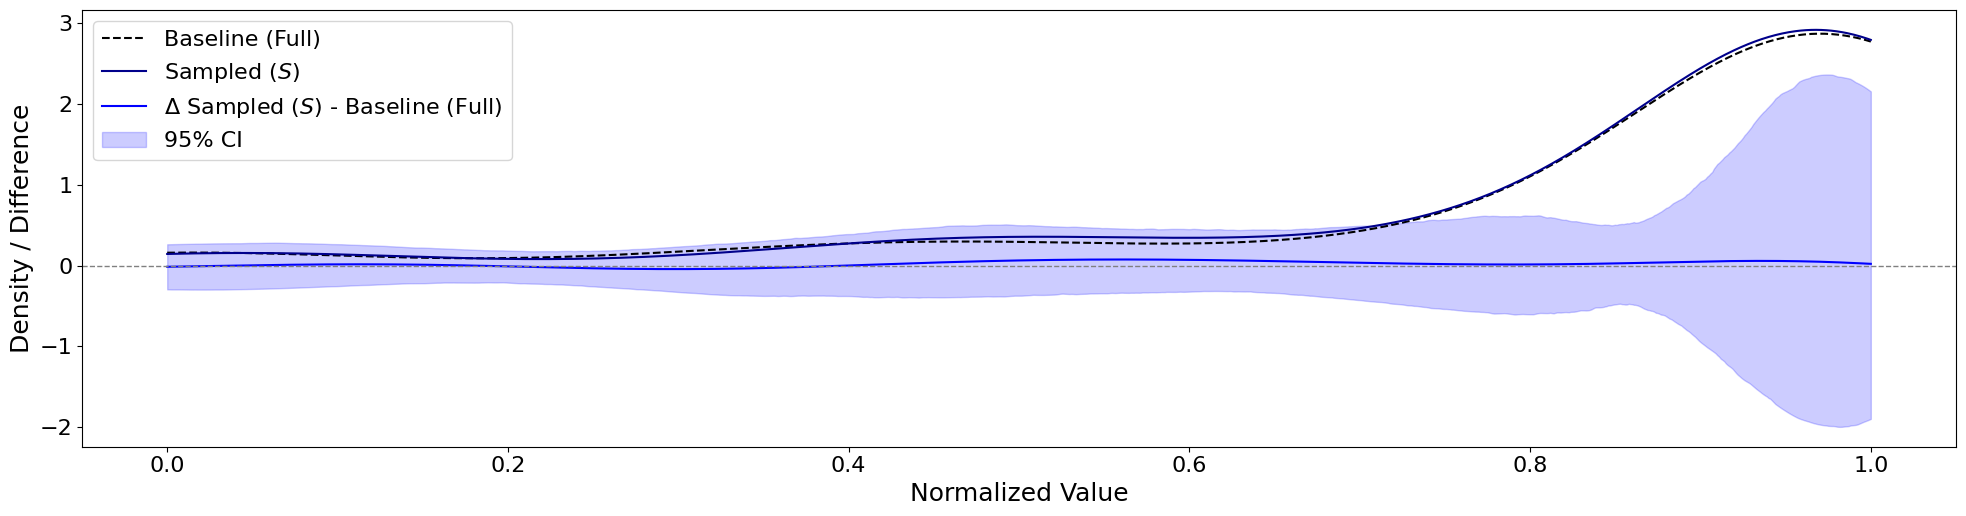

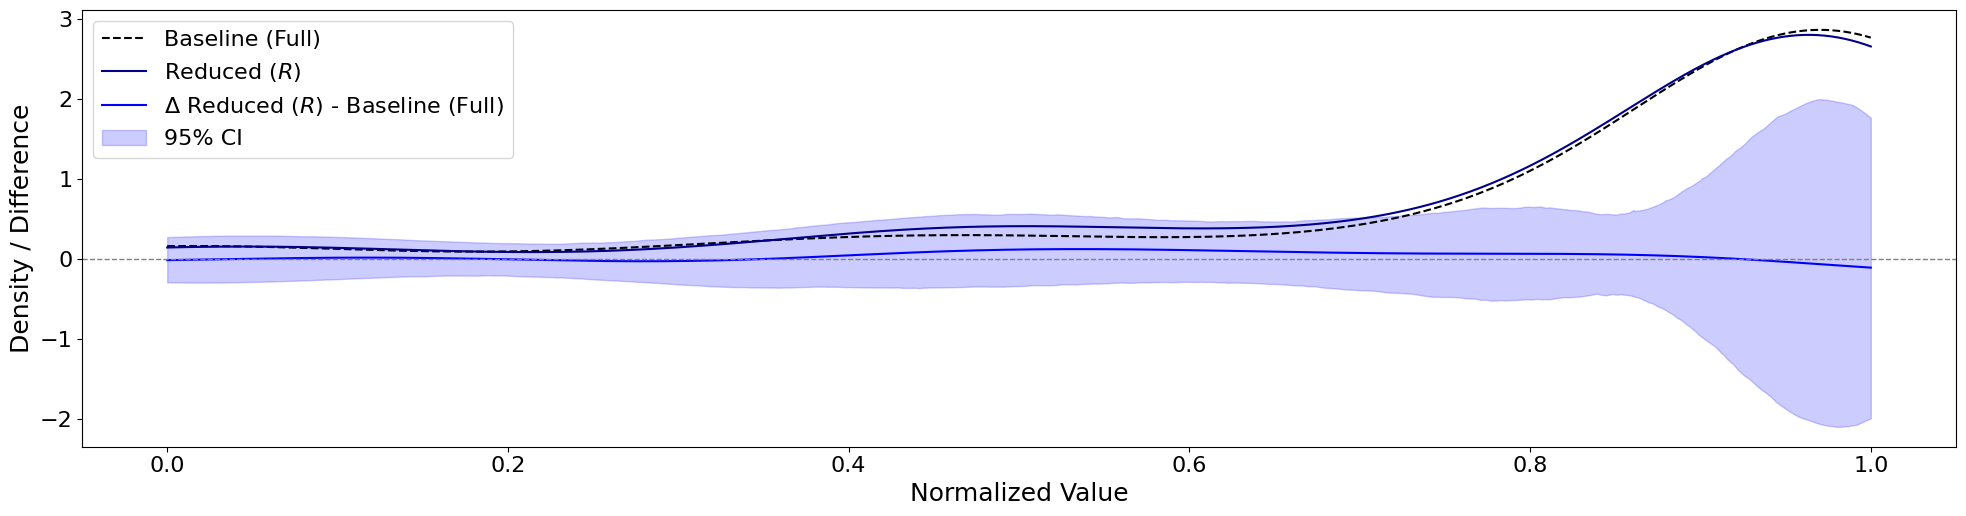

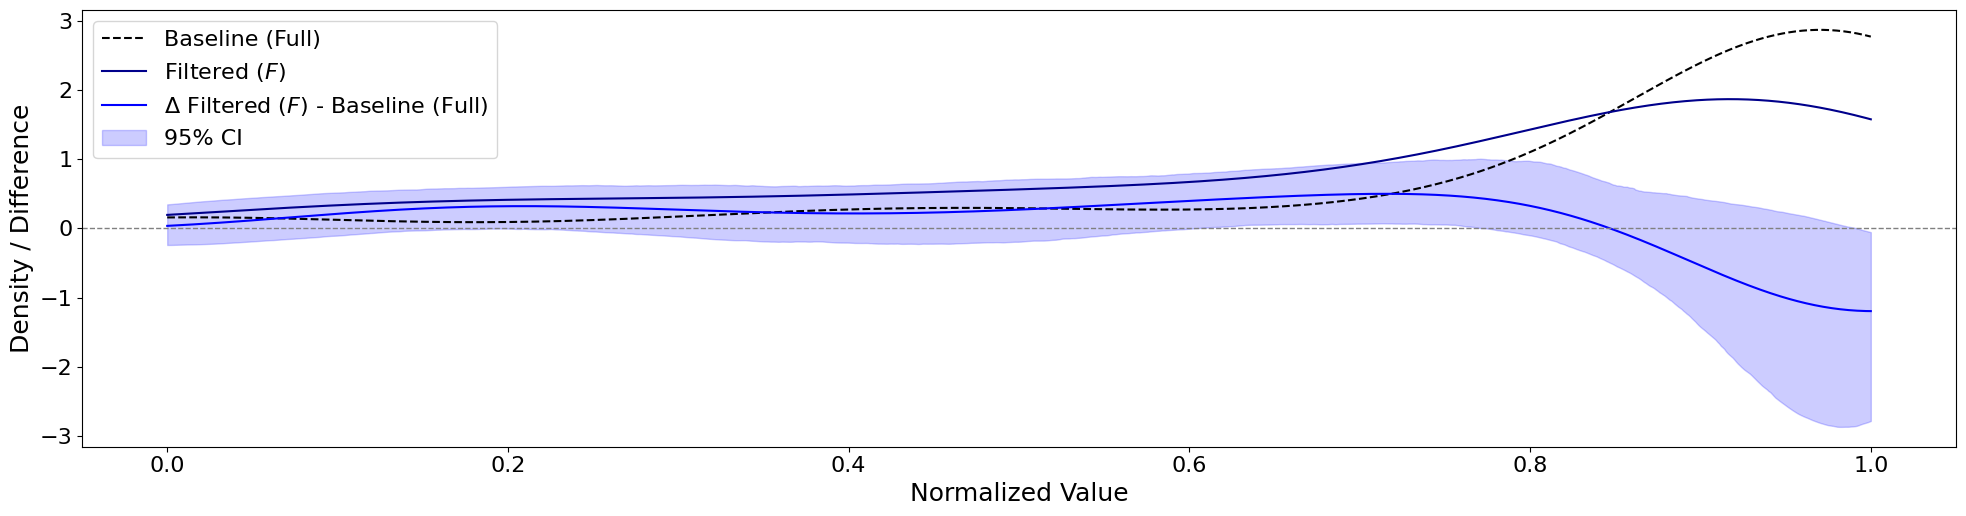

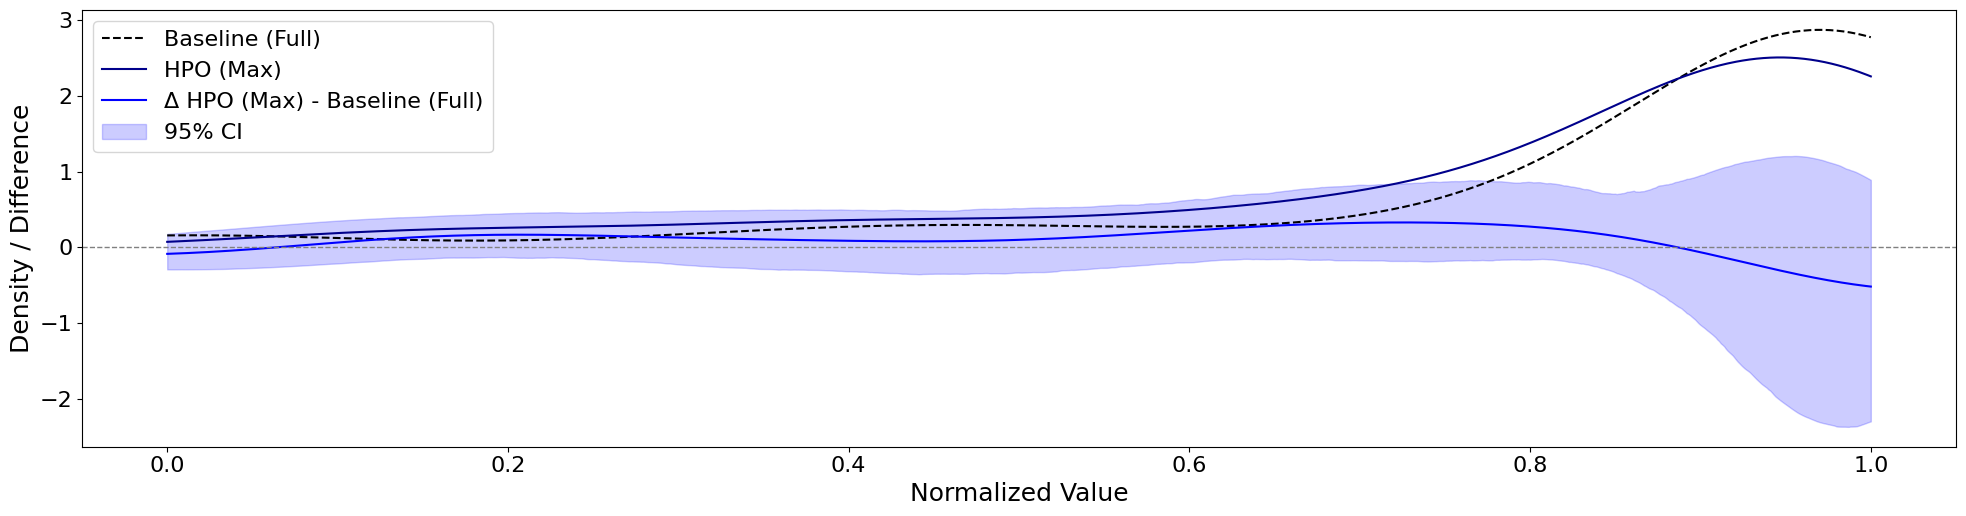

In [19]:
# Setup
ref_col = "f1_full"
columns = [col for col in perf_cols_f1 if col != ref_col]
x_vals = np.linspace(df_numeric[perf_cols_f1].min().min(),
                     df_numeric[perf_cols_f1].max().max(), 1000)

ref_data = df_numeric[ref_col].dropna().values
ref_kde = gaussian_kde(ref_data)(x_vals)
ref_lower, ref_upper = bootstrap_kde_ci(ref_data, x_vals)

col_map = {
    'f1_full': 'Baseline (Full)',
    'f1_sampled': 'Sampled ($S$)',
    'f1_reduced': 'Reduced ($R$)',
    'f1_filtered': 'Filtered ($F$)',
    'f1_hpo_max': 'HPO (Max)'
}

for col in columns:
    target_data = df_numeric[col].dropna().values
    target_kde = gaussian_kde(target_data)(x_vals)
    target_lower, target_upper = bootstrap_kde_ci(target_data, x_vals)

    # Difference and CI
    diff = target_kde - ref_kde
    diff_lower = target_lower - ref_upper
    diff_upper = target_upper - ref_lower

    # Plot
    plt.figure(figsize=(20, 5.5))
    plt.plot(x_vals, ref_kde, label=f"{col_map[ref_col]}", color='black', linestyle='--')
    plt.plot(x_vals, target_kde, label=f"{col_map[col]}", color='darkblue')
    plt.plot(x_vals, diff, label=f"Δ {col_map[col]} - {col_map[ref_col]}", color='blue')
    plt.fill_between(x_vals, diff_lower, diff_upper, alpha=0.2, color='blue', label="95% CI")
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Labels
    plt.xlabel("Normalized Value")
    plt.ylabel("Density / Difference")
    plt.legend()
    plt.tight_layout()

    # Save and show
    plt.savefig(f"plots/kde_{col}_vs_{ref_col}.pdf", dpi=300)
    plt.show()
    plt.close()

# KDE Analysis - Training Time

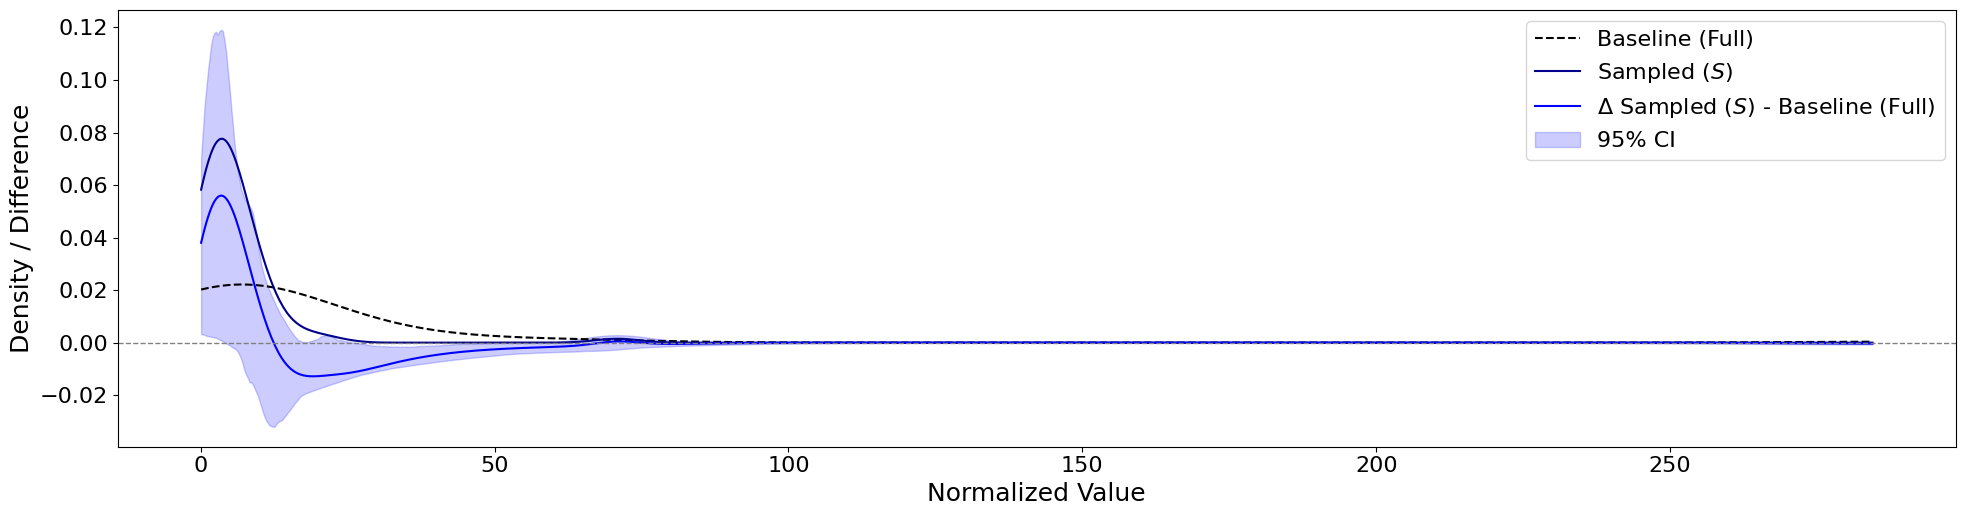

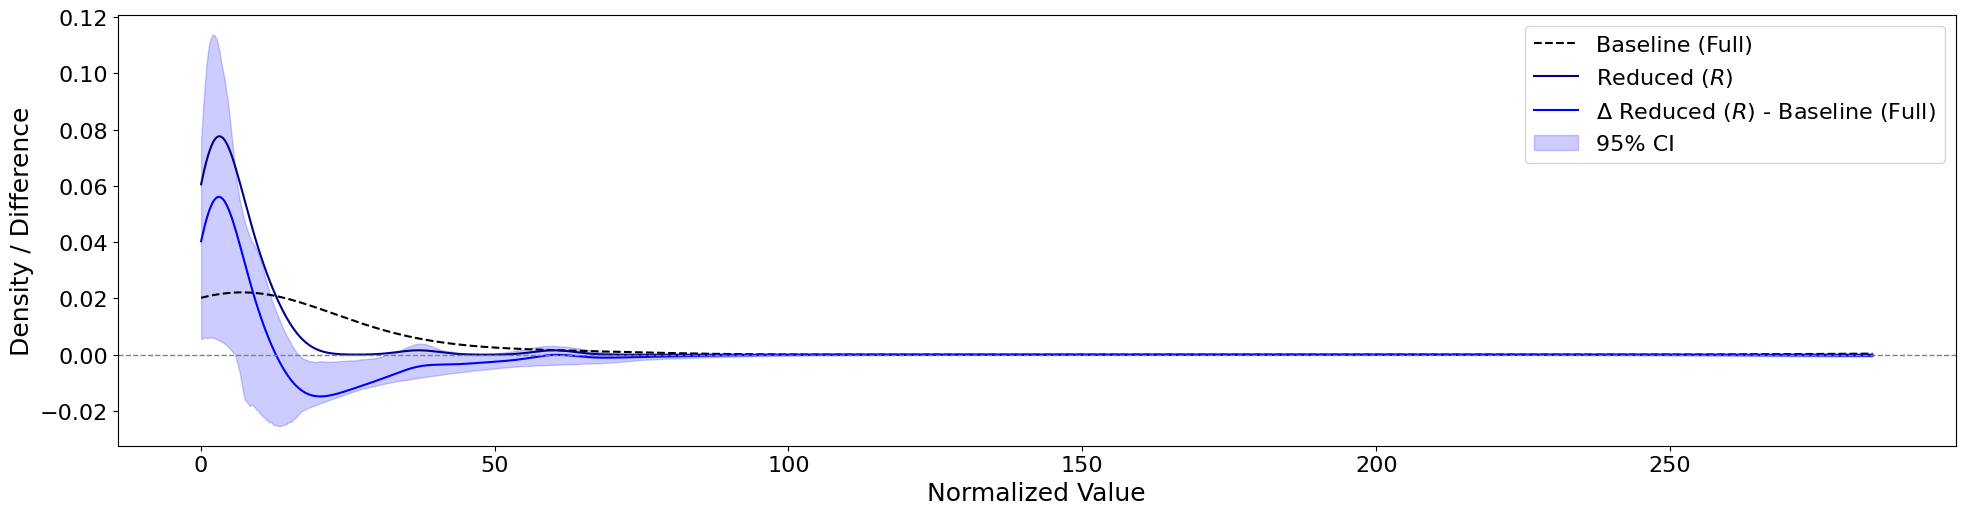

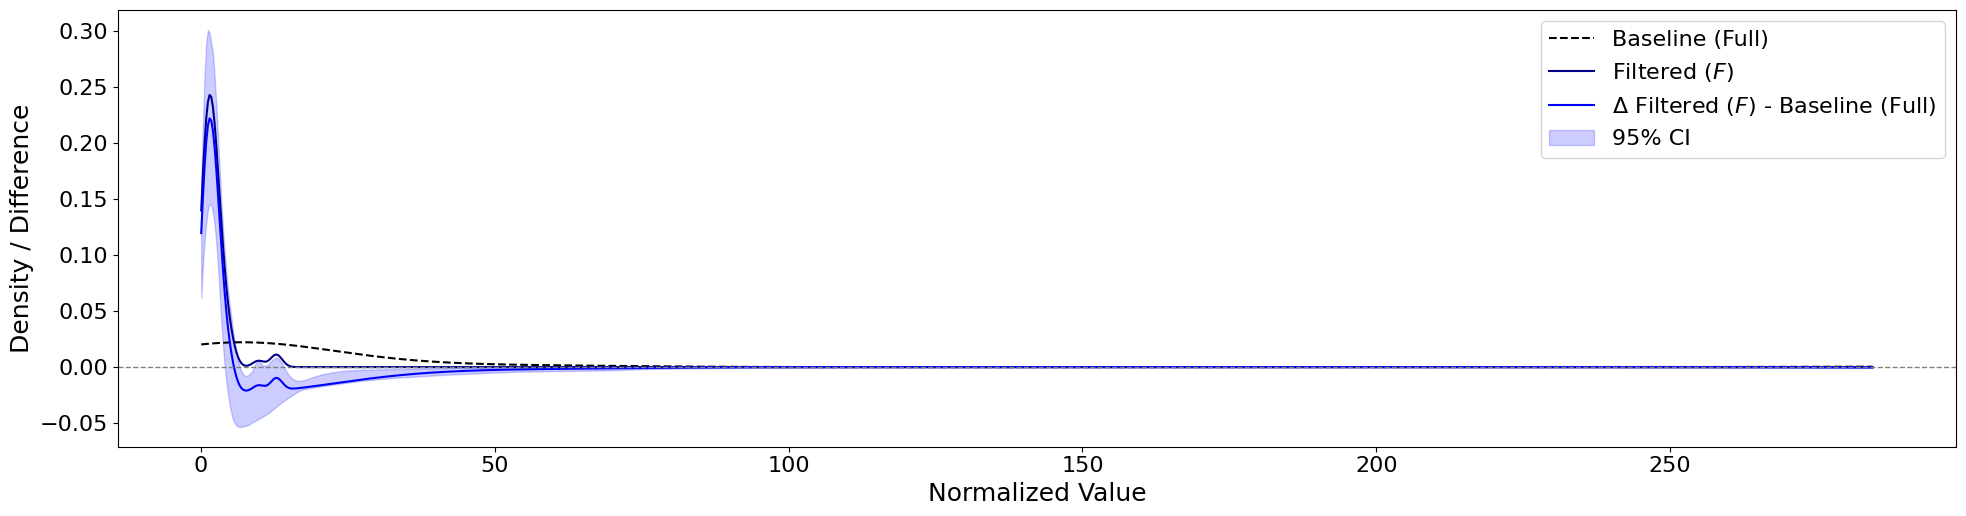

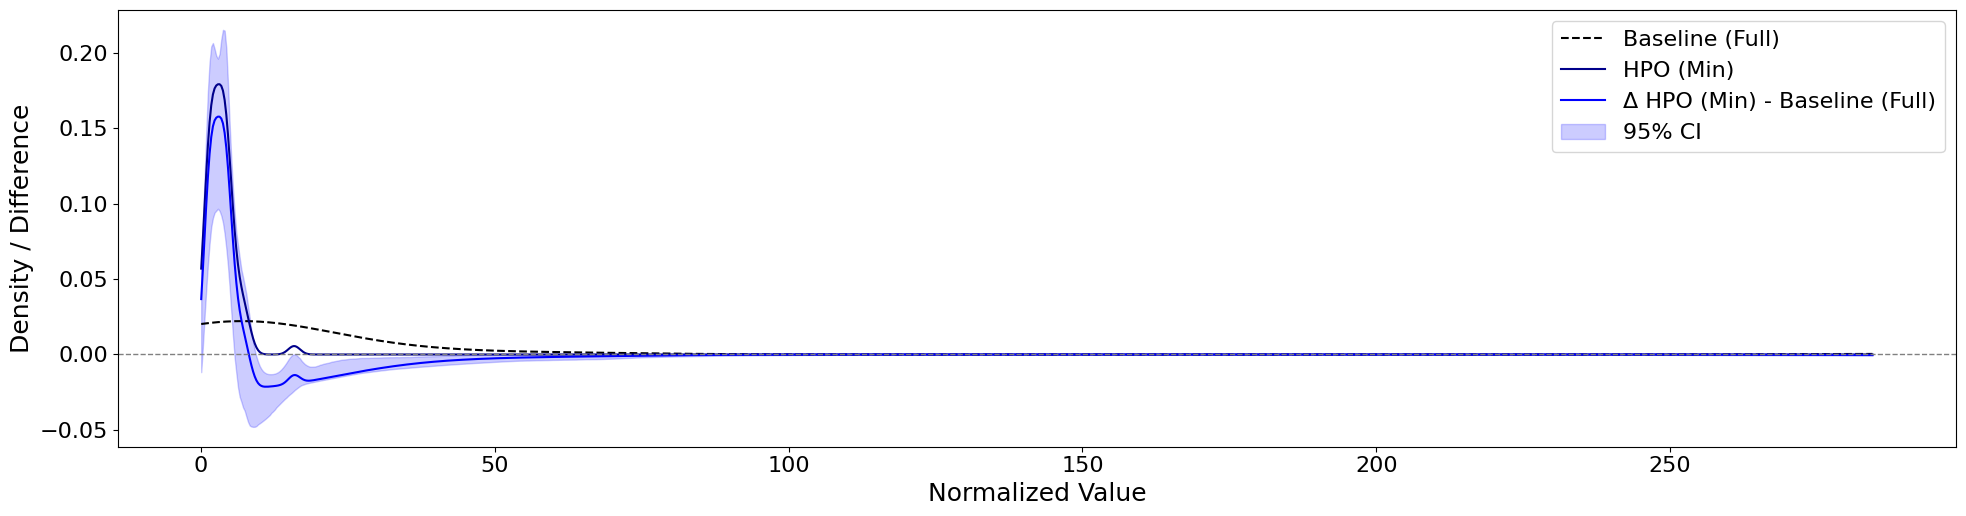

In [20]:
# Setup
ref_col = "time_full"
columns = [col for col in perf_cols_time if col != ref_col]
x_vals = np.linspace(df_numeric[perf_cols_time].min().min(),
                     df_numeric[perf_cols_time].max().max(), 1000)

df_numeric["time_full"] = pd.to_numeric(df_numeric["time_full"], errors="coerce")
ref_data = df_numeric["time_full"].dropna().astype(float).values
ref_kde = gaussian_kde(ref_data)(x_vals)
ref_lower, ref_upper = bootstrap_kde_ci(ref_data, x_vals)

col_map = {
    'time_full': 'Baseline (Full)',
    'time_sampled': 'Sampled ($S$)',
    'time_reduced': 'Reduced ($R$)',
    'time_filtered': 'Filtered ($F$)',
    'time_hpo_min': 'HPO (Min)'
}

for col in columns:
    df_numeric[col] = pd.to_numeric(df_numeric[col], errors="coerce")
    target_data = df_numeric[col].dropna().astype(float).values
    target_kde = gaussian_kde(target_data)(x_vals)
    target_lower, target_upper = bootstrap_kde_ci(target_data, x_vals)

    # Difference and CI
    diff = target_kde - ref_kde
    diff_lower = target_lower - ref_upper
    diff_upper = target_upper - ref_lower

    # Plot
    plt.figure(figsize=(20, 5.5))
    plt.plot(x_vals, ref_kde, label=f"{col_map[ref_col]}", color='black', linestyle='--')
    plt.plot(x_vals, target_kde, label=f"{col_map[col]}", color='darkblue')
    plt.plot(x_vals, diff, label=f"Δ {col_map[col]} - {col_map[ref_col]}", color='blue')
    plt.fill_between(x_vals, diff_lower, diff_upper, alpha=0.2, color='blue', label="95% CI")
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Labels
    plt.xlabel("Normalized Value")
    plt.ylabel("Density / Difference")
    plt.legend()
    plt.tight_layout()

    # Save and show
    plt.savefig(f"plots/kde_{col}_vs_{ref_col}.pdf", dpi=300)
    plt.show()
    plt.close()

# KDE Analysis - Model Size

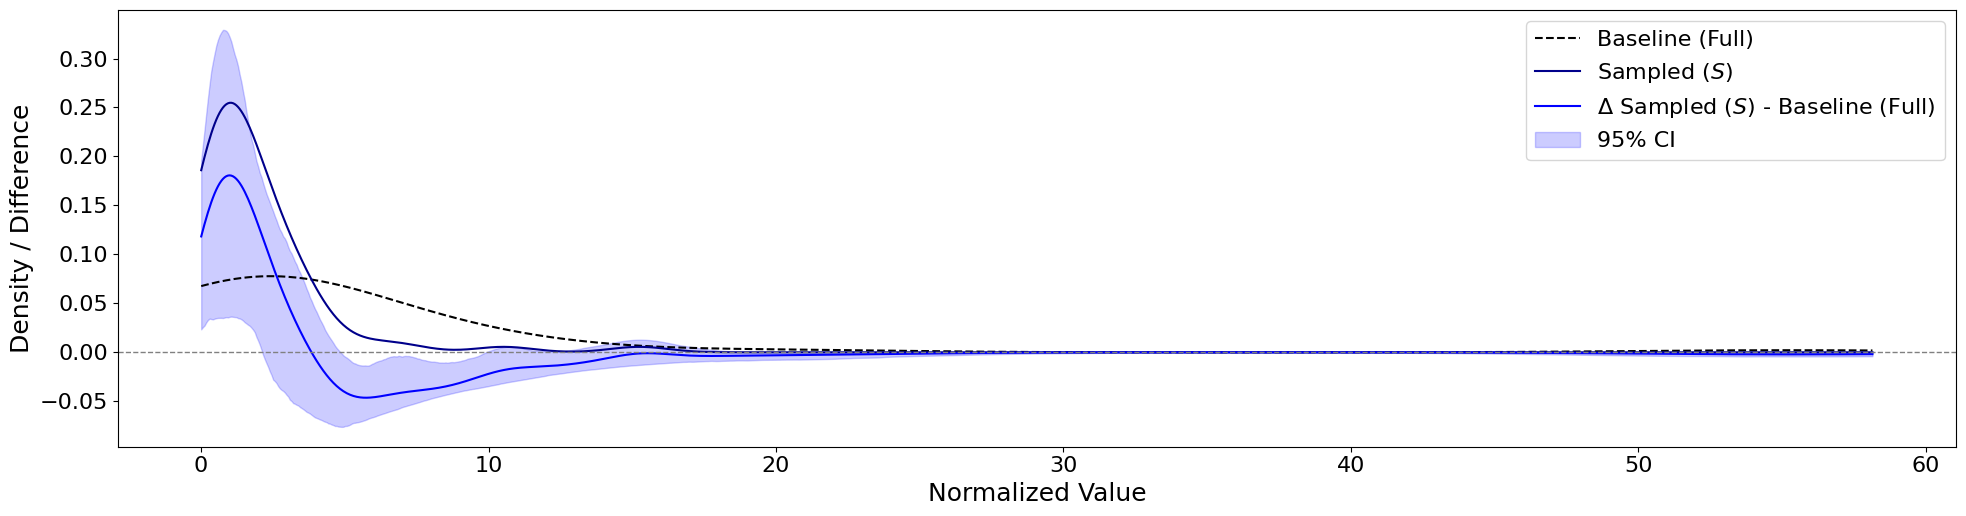

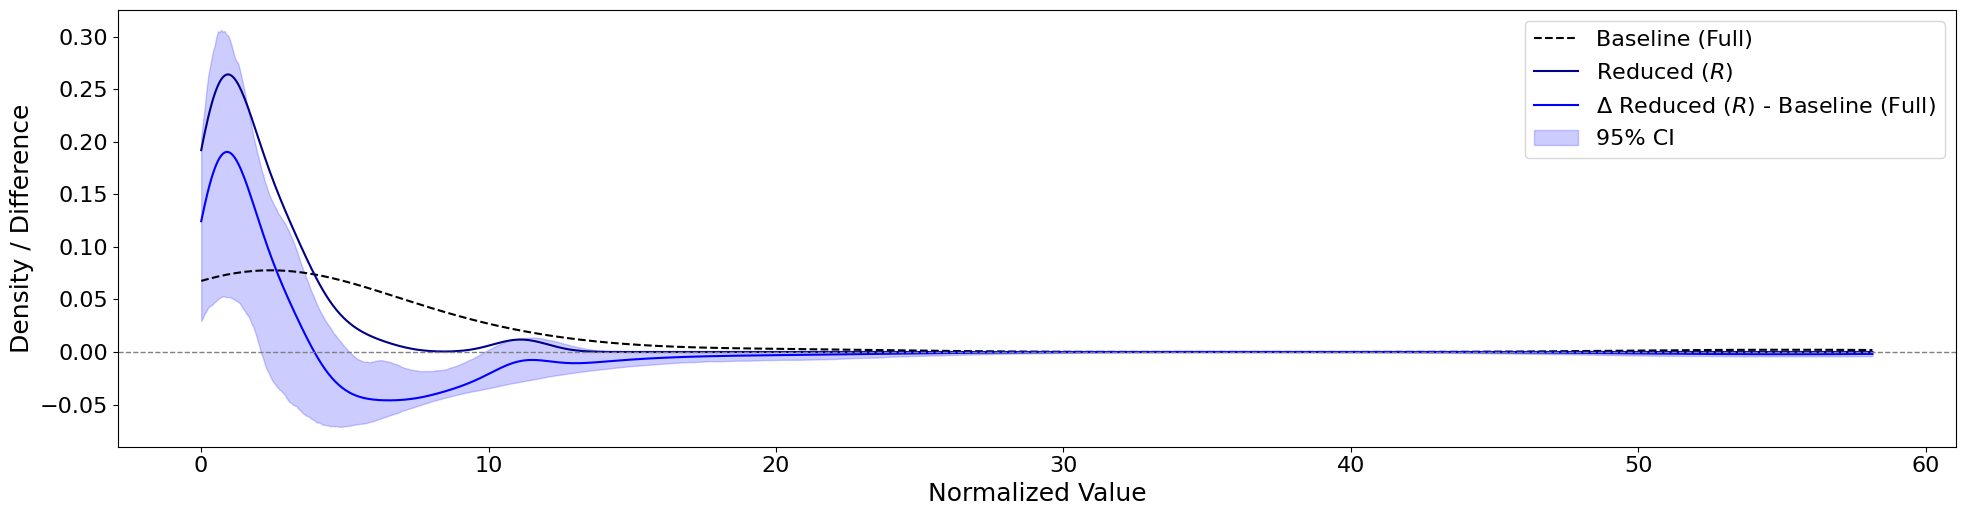

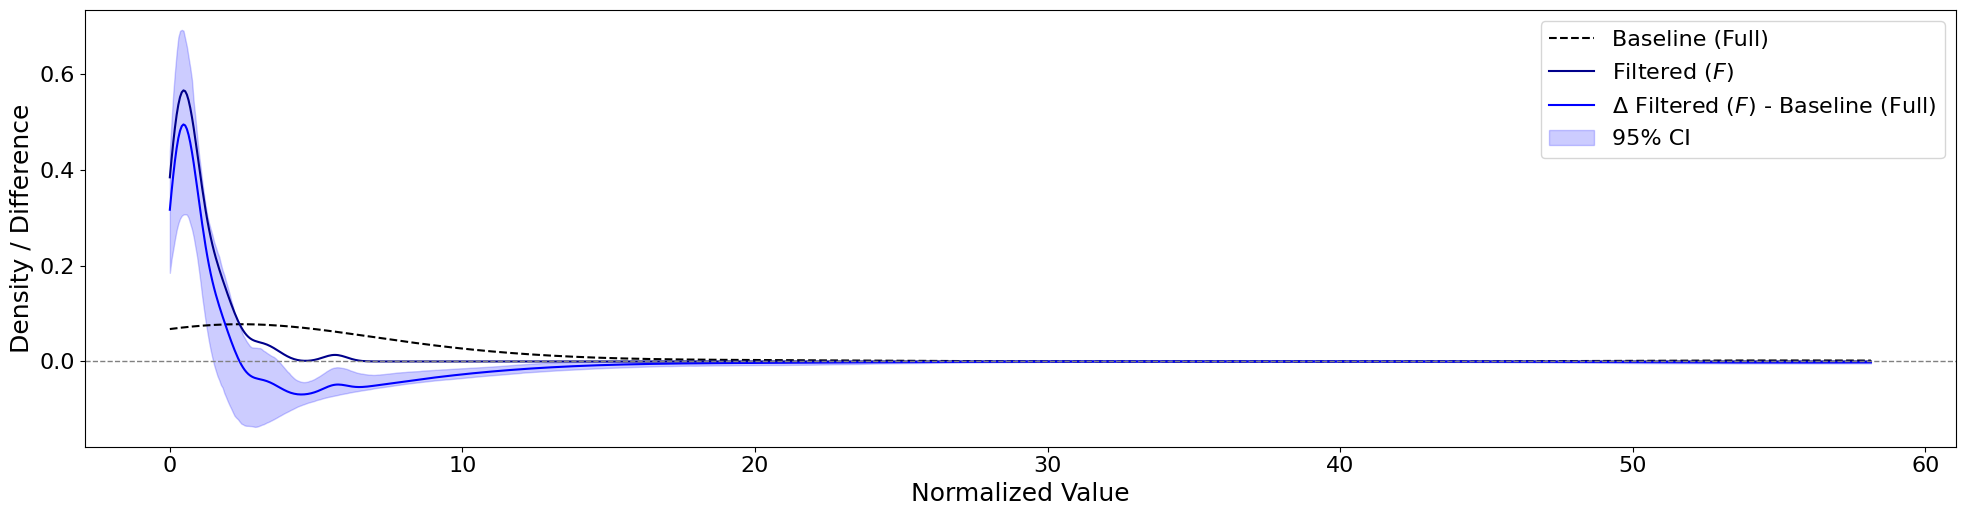

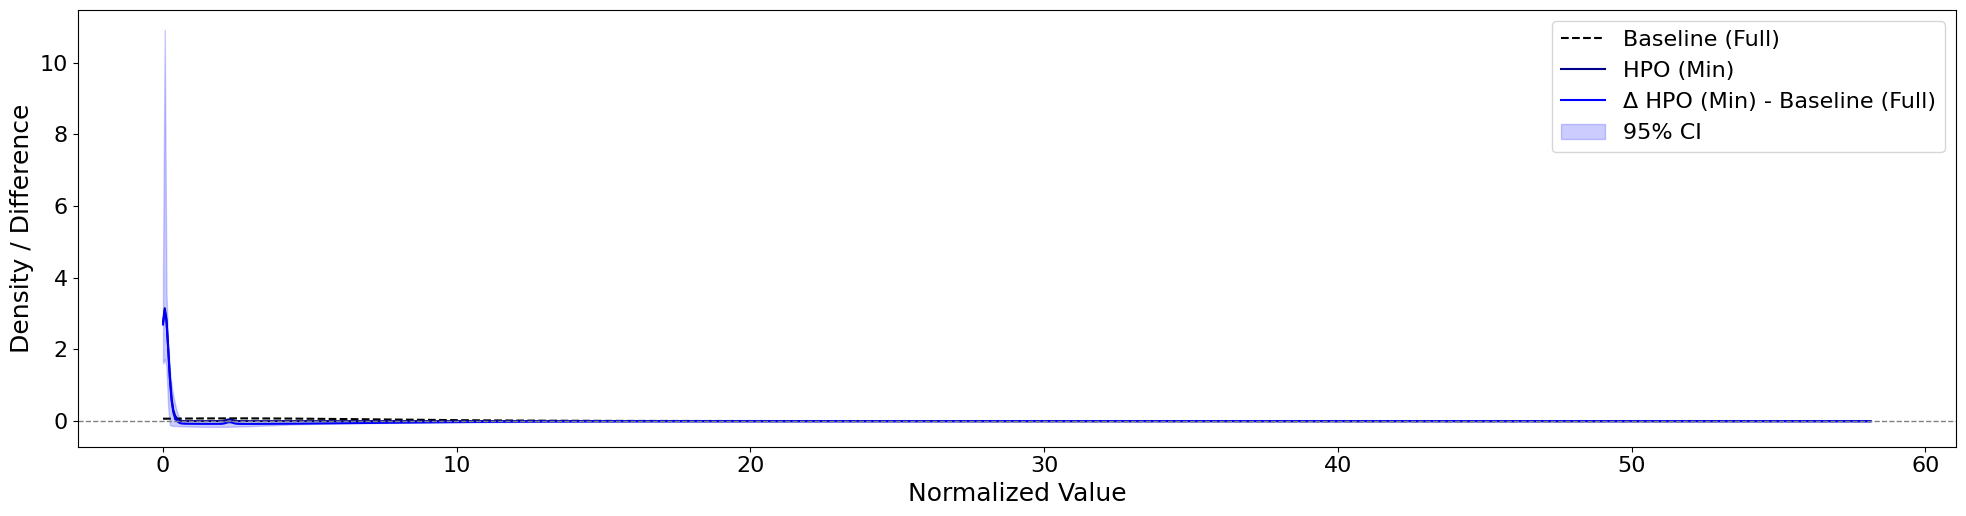

In [21]:
# Setup
ref_col = "size_full"
columns = [col for col in perf_cols_size if col != ref_col]
x_vals = np.linspace(df_numeric[perf_cols_size].min().min(),
                     df_numeric[perf_cols_size].max().max(), 1000)

df_numeric["size_full"] = pd.to_numeric(df_numeric["size_full"], errors="coerce")
ref_data = df_numeric["size_full"].dropna().astype(float).values
ref_kde = gaussian_kde(ref_data)(x_vals)
ref_lower, ref_upper = bootstrap_kde_ci(ref_data, x_vals)

col_map = {
    'size_full': 'Baseline (Full)',
    'size_sampled': 'Sampled ($S$)',
    'size_reduced': 'Reduced ($R$)',
    'size_filtered': 'Filtered ($F$)',
    'size_hpo_min': 'HPO (Min)'
}

for col in columns:
    df_numeric[col] = pd.to_numeric(df_numeric[col], errors="coerce")
    target_data = df_numeric[col].dropna().astype(float).values
    target_kde = gaussian_kde(target_data)(x_vals)
    target_lower, target_upper = bootstrap_kde_ci(target_data, x_vals)

    # Difference and CI
    diff = target_kde - ref_kde
    diff_lower = target_lower - ref_upper
    diff_upper = target_upper - ref_lower

    # Plot
    plt.figure(figsize=(20, 5.5))
    plt.plot(x_vals, ref_kde, label=f"{col_map[ref_col]}", color='black', linestyle='--')
    plt.plot(x_vals, target_kde, label=f"{col_map[col]}", color='darkblue')
    plt.plot(x_vals, diff, label=f"Δ {col_map[col]} - {col_map[ref_col]}", color='blue')
    plt.fill_between(x_vals, diff_lower, diff_upper, alpha=0.2, color='blue', label="95% CI")
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Labels
    plt.xlabel("Normalized Value")
    plt.ylabel("Density / Difference")
    plt.legend()
    plt.tight_layout()

    # Save and show
    plt.savefig(f"plots/kde_{col}_vs_{ref_col}.pdf", dpi=300)
    plt.show()
    plt.close()

In [22]:
def summarize_results(df_filename, results_filename):
    df = pd.read_excel(results_filename)
    row_full = df.loc[df['Unnamed: 0'] == 'full', 'X_train_shape'].values[0]
    row_max = df.loc[df['f1_score_abs'].idxmax()].to_dict()
    if 'Unnamed: 0' in row_max:
        row_max['best_config'] = row_max.pop('Unnamed: 0')
    summary = {'filename': df_filename, 'shape': row_full,}
    summary.update(row_max)
    return summary

In [23]:
base_folder = Path("/home/automl/git/iot-threat-classifier/2025-06-28/Output_Multiclass")

summary_rows = []

# Find all .parquet files recursively
result_files = list(base_folder.rglob("*table.xlsx"))

# Iterate
for file in tqdm(result_files, desc='File', leave='False'):

    try:
        short_filename = str(file.parent.stem)
        row = summarize_results(short_filename, file)
        summary_rows.append(row)
        
    except (ValueError, Exception) as e:
        tqdm.write(f'[{now()}] ERROR      | FILE = {str(file.stem):<64} | EXCEPTION = {e}')

File:   0%|          | 0/66 [00:00<?, ?it/s]

In [24]:
output_df = pd.DataFrame(summary_rows).set_index("filename")

output_df

,shape,X_train_shape,X_val_shape,X_test_shape,model_size_abs,model_size_delta,training_time_abs,training_time_delta,latency_abs,latency_delta,f1_score_abs,f1_score_delta,hpo_n_trials,hpo_params,best_config
filename,,,,,,,,,,,,,,,
CICEVSE2024_EVSE-B_Macro_Multiclass,"(171987, 68)","(17190, 68)","(57329, 68)","(57329, 68)",1.36,-0.48 (-26.09%),3.851,-2.049717 (-34.74%),3.865710e-07,-6.18e-07 (-61.51%),0.948975,+0.001143 (+0.11%),--,--,sampled
NIDS_NF-ToN-IoT-v2_Multiclass,"(699477, 38)","(699477, 38)","(233159, 38)","(233158, 38)",10.85,+0.00 (+0.00%),33.318,--,4.431470e-07,--,0.887541,--,--,--,full
ToN_IoT_Network_Multiclass,"(282243, 40)","(282243, 40)","(94081, 40)","(94081, 40)",6.51,+0.00 (+0.00%),20.285,--,6.354210e-07,--,0.982596,--,--,--,full
N_BaIoT_SimpleHome_XCS7_1003_WHT_Security_Camera_Multiclass,"(329363, 115)","(329363, 115)","(109788, 115)","(109787, 115)",2.39,+0.00 (+0.00%),10.981,--,5.893960e-07,--,0.999852,--,--,--,full
NIDS_NF-BoT-IoT-v2_Multiclass,"(85853, 38)","(85853, 38)","(28617, 38)","(28617, 38)",8.56,+0.00 (+0.00%),12.962,--,2.923850e-06,--,0.907984,--,--,--,full
NIDS_CIC-ToN-IoT_Multiclass,"(101735, 71)","(10176, 31)","(33911, 31)","(33911, 31)",0.93,-0.53 (-36.30%),3.128,+0.009085 (+0.29%),3.329400e-07,-2.21e-07 (-39.86%),0.880905,+0.010080 (+1.01%),--,--,reduced
N_BaIoT_Philips_B120N10_Baby_Monitor_Multiclass,"(471723, 115)","(471723, 115)","(157241, 115)","(157240, 115)",2.32,+0.00 (+0.00%),13.062,--,4.514050e-07,--,0.999910,--,--,--,full
ToN_IoT_Linux_Disk_Multiclass,"(14495, 5)","(1445, 5)","(4832, 5)","(4831, 5)",1.38,-2.80 (-66.99%),1.187,-1.543635 (-56.53%),1.860366e-06,-2.00e-08 (-1.07%),0.580356,+0.029170 (+2.92%),--,--,sampled
CICAPT_IIoT_Phase2_Macro_Multiclass,"(4925659, 48)","(4925659, 48)","(1641886, 48)","(1641886, 48)",6.48,+0.00 (+0.00%),92.517,--,6.500510e-07,--,0.999988,--,--,--,full


In [25]:
summary_df = input_df.data.join(output_df, how='left')

summary_df

NameError: name 'input_df' is not defined

In [ ]:
summary_df.to_excel("/home/automl/git/iot-threat-classifier/2025-06-28/summary.xlsx")

In [ ]:
summary_df[summary_df.isna().any(axis=1)]

In [ ]:
summary_df[summary_df.isna().any(axis=1)].to_excel("/home/automl/git/iot-threat-classifier/2025-06-28/errors.xlsx")